In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_mm400 = pd.read_excel("./data/MM400_HF2_0_5_5.xlsx")

In [41]:
# df_nrwm = pd.read_excel("./data/NRWM_HF2_5_5_5.xlsx", sheet_name=1)
df_nrwm = pd.read_excel("./data/NRWM_Dennis_210108.xlsx", sheet_name=1)


In [42]:
df_mm400.head()

,TIME,C
0,0,0.159
1,50,0.357
2,100,0.732
3,150,0.560
4,200,0.335


In [43]:
df_nrwm.head()

,TIME,C
0,0,-0.002599
1,5,-0.007635
2,10,-0.005685
3,15,-0.004223
4,20,-0.014621


In [44]:
# Set configuration constants
tTimeBase = 1e-6
thresholdHi = 0.9
thresholdLo = 0.1

In [45]:
# helpers
def sq(x): 
    return x*x


def plotResults(**kwargs):
    
### Plot results ###
    
#     df = dataFrame of TIME and CURRENT values
#     valueField: string -- name of dataFrame field with current values
#     timeField: string -- name of dataFrame field with time values
#     hiThresholdPoint: tuple (<time>, <value>) -- value of point where instantaneous current crosses the high threshold 
#     loThresholdPoint: tuple (<time>, <value>) -- value of point where instantaneous current crosses the low threshold
#     thresholds: tuple (<high threshold>, <low threshold>) -- threshold values in interval (0 , 1]
#     ylimits: tuple (ymin, ymax) -- vertical extents of plot
#     title: string

    df = kwargs["df"]
    trigTime = kwargs["trigTime"]
    valueField = kwargs["valueField"]
    timeField = kwargs["timeField"]
    ISO_RMS = kwargs["ISO_RMS"]
    hiThresholdPoint = kwargs["hiThresholdPoint"]
    loThresholdPoint = kwargs["loThresholdPoint"]
    thresholds = kwargs["thresholds"]
    yLimits = kwargs["yLimits"]
    title = kwargs["title"]

        
    xHi, yHi = (hiThresholdPoint[0], hiThresholdPoint[1])
    xLo, yLo = (loThresholdPoint[0], loThresholdPoint[1])
    
    xMin, xMax = 0, df[timeField].values[-1]*tTimeBase
    yMin, yMax = yLimits
    
    threshHi, threshLo = thresholds
    
    timeScale = 1/tTimeBase

    f, ax = plt.subplots(1,1,figsize=(15,10))
    
    # Plot critical points
    ax.plot(xHi,yHi,"bs",markersize=10, fillstyle='none')
    ax.plot(xLo,yLo,"gs",markersize=10, fillstyle='none')
    
    # Plot some convenience lines and text
    ax.hlines([ISO_RMS, threshHi*ISO_RMS, threshLo*ISO_RMS], 0, xMax, linestyles='dashed', colors=["blue", "red", "red"])
    ax.vlines(xHi, 0, yMax - 0.1, linestyles='dashed', colors='red')
    ax.vlines(xLo, 0, 0.2, linestyles='dashed', colors='red')
    
    legend = ["Qualifying point", "Qualifying point",
              f"ISO RMS", f"{thresholds[0]:.0%}",f"{thresholds[1]:.0%}"        ]
    ax.legend(legend,loc='best')
    
    # Plot instantaneous data
    ax.plot(df[timeField]*tTimeBase, df[valueField],"ro")
    ax.plot(df[timeField]*tTimeBase, df[valueField])
    
    ftitle = title + "\n" + f"RMS measurement time = {1000*xHi:.3} mSec\nCurrent flow time = {1000*xLo:.3} mSec\nISO RMS: {ISO_RMS:.5} kA"
    plt.title(ftitle)
    
    ax.set_xlabel("Time (mSec)")
    ax.set_ylabel("Current (kA)")
    
    ax.grid()
    plt.savefig(f"figs/ISORMS {title}.png",bbox_inches="tight")
    #plt.show()
   # ax.savefig("figs/ISORMS.png",bbox_inches="tight")

In [52]:
# main process
def calculateISO_RMS(df, trigTime,  valueField, timeField, threshHi, threshLo):
    
    meanSquare = 0
    index = 0
    
    # Capture and store the points where the instantaneous value crosses the high and low threshold of the RMS value
    #  computed up to that point.
    # Each point is described by a tuple: (dataPoint_time, dataPoint_value)
    candidateHi = (0, 0)
    candidateLo = (0, 0)
    ISO_meanSquare = 0
    trigIndex = df.query(timeField + "== 5000").index
    print(trigIndex)
    dataPoint_last = df.loc[trigIndex,valueField]
    
    # Read in the data, compute RMS using "on-line" method, and test for candidacy 
    # Dataframe index is continguous integers starting at 0
    timeIndex = [t for t in df.index if t >= trigIndex]
    for i in timeIndex:
        if i > trigIndex:
            dataPoint_last = df.loc[i-1,valueField]
            dataPoint_next = df.loc[i,valueField]
            timeNext = df.loc[i,timeField]*tTimeBase
        
            meanSquare = 1/i * ((i-1)*meanSquare + sq(dataPoint_next)) # on-line calculation

            # We do comparison tests with mean square values to avoid computation burden of doing a square-root each time.
            # We capture points that qualify as a high to low transition across the high threshold point.  
            # In the case of high ripple or other irregularities in the instantaneous current signal, the last point
            #  captured will represent the final transition point.
            if np.sign(dataPoint_last)*sq(dataPoint_last) > meanSquare * sq(threshHi) and np.sign(dataPoint_next)*sq(dataPoint_next) < meanSquare * sq(threshHi):
                candidateHi = (timeNext, dataPoint_next)
                ISO_meanSquare = meanSquare

            # For the high to low transistion acrosss the low threshold point, we compare to the last mean square 
            #  value detected by the last high to low transition across the high threshold point
            if np.sign(dataPoint_last)*sq(dataPoint_last)  > ISO_meanSquare * sq(threshLo) and np.sign(dataPoint_next)*sq(dataPoint_next) < ISO_meanSquare * sq(threshLo):
                candidateLo =  (timeNext, dataPoint_next)
        #print(candidateHi, candidateLo)
    ISO_RMS = np.sqrt(ISO_meanSquare)
    return ISO_RMS, candidateHi, candidateLo
                            

In [53]:
df = df_mm400
df = df_nrwm

field_mm400 = "C"
field_nrwm = "C"

timeField_mm400 = 'TIME'
timeField_nrwm = 'TIME'

TRIG_TIME = 0

threshHi = 0.9
threshLo = 0.1

Int64Index([1000], dtype='int64')
(0.016905, 0.00731)


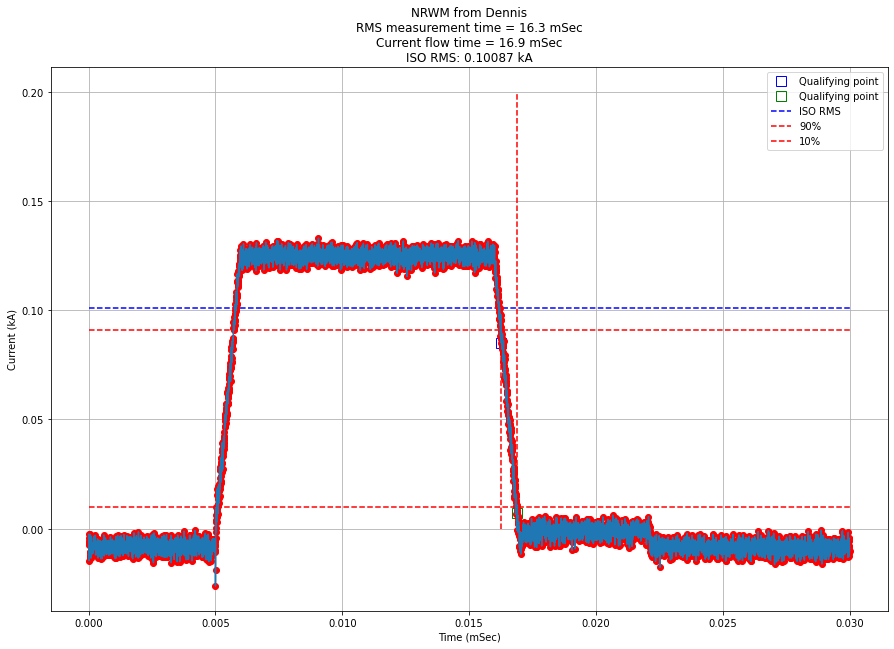

In [54]:
# def findEndOfWeldCandidates(df, field, threshHi, threshLo):
ISO_RMS, candidateHi, candidateLo = calculateISO_RMS(df, TRIG_TIME, field_mm400,timeField_mm400, threshHi, threshLo)
print(candidateLo)
# def  plotResults(df, valueField, timeField, hiThresholdPoint, loThresholdPoint, thresholds, ylimits):
plotResults(df=df, 
            trigTime=TRIG_TIME,
            valueField=field_mm400, 
            timeField=timeField_mm400, 
            ISO_RMS=ISO_RMS, 
            hiThresholdPoint=candidateHi, 
            loThresholdPoint=candidateLo, 
            thresholds=(0.9, 0.1), 
            yLimits=(0, 0.2),
            title="NRWM from Dennis")